In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [24]:
df = pd.read_csv('dataset_diabetes/diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Data Preprocessing

1. The variable medical_specialty is important feature however it has too many distinct values. Hence we grouped them to reduce the number of categories.

In [25]:
high_frequency = ['InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive', 
                 'Emergency/Trauma', 'Urology','ObstetricsandGynecology','Psychiatry','Pulmonology ','Nephrology','Radiologist']

low_frequency = ['Surgery-PlasticwithinHeadandNeck','Psychiatry-Addictive','Proctology','Dermatology','SportsMedicine','Speech','Perinatology',\
                'Neurophysiology','Resident','Pediatrics-Hematology-Oncology','Pediatrics-EmergencyMedicine','Dentistry','DCPTEAM','Psychiatry-Child/Adolescent',\
                'Pediatrics-Pulmonology','Surgery-Pediatric','AllergyandImmunology','Pediatrics-Neurology','Anesthesiology','Pathology','Cardiology-Pediatric',\
                'Endocrinology-Metabolism','PhysicianNotFound','Surgery-Colon&Rectal','OutreachServices',\
                'Surgery-Maxillofacial','Rheumatology','Anesthesiology-Pediatric','Obstetrics','Obsterics&Gynecology-GynecologicOnco']

pediatrics = ['Pediatrics','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology','Pediatrics-Hematology-Oncology',\
               'Pediatrics-Neurology','Pediatrics-Pulmonology', 'Anesthesiology-Pediatric', 'Cardiology-Pediatric', 'Surgery-Pediatric']

psychic = ['Psychiatry-Addictive', 'Psychology', 'Psychiatry',  'Psychiatry-Child/Adolescent', 'PhysicalMedicineandRehabilitation', 'Osteopath']


neurology = ['Neurology', 'Surgery-Neuro',  'Pediatrics-Neurology', 'Neurophysiology']


surgery = ['Surgeon', 'Surgery-Cardiovascular', \
          'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', \
             'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',  'Surgery-Thoracic',\
             'Surgery-Vascular', 'SurgicalSpecialty', 'Podiatry']
             
others = ['Endocrinology','Gastroenterology','Gynecology','Hematology','Hematology/Oncology','Hospitalist','InfectiousDiseases',\
           'Oncology','Ophthalmology','Otolaryngology','Pulmonology','Radiology']


missing = ['?']


In [26]:
colMedical = []

for val in df['medical_specialty'] :
    if val in pediatrics :
        colMedical.append('pediatrics')
    elif val in psychic :
        colMedical.append('psychic')
    elif val in neurology :
        colMedical.append('neurology')
    elif val in surgery :
        colMedical.append('surgery')
    elif val in high_frequency :
        colMedical.append('high_freq')
    elif val in low_frequency :
        colMedical.append('low_freq')
    elif val in others :
        colMedical.append('others')
    elif val in missing :
        colMedical.append('missing')
    else:
        colMedical.append('?')
        
df['medical_specialty'] = colMedical

3. Handling Duplicate entries

In [27]:
df.dropna(inplace = True)
print('Total length of the data = ', len(df))
print('Number of unique entries = ', len(np.unique(df['patient_nbr'])))
df.drop_duplicates(['patient_nbr'], keep = 'first', inplace = True)
print('Length after removing duplicates:', len(df))

Total length of the data =  101766
Number of unique entries =  71518
Length after removing duplicates: 71518


4. Missing values in this dataset are represented by ‘?’. Find the number of missing values for each variable.

In [28]:
temp = pd.DataFrame(columns=['Column Name', 'Missing Values', 'Missing Percentage'])
for col in df.columns:
    l = len(df[df[col] == '?'])
    temp.loc[len(temp.index)] = [col, l, int((l / len(df))*100)]
print(temp)

                 Column Name Missing Values Missing Percentage
0               encounter_id              0                  0
1                patient_nbr              0                  0
2                       race           1948                  2
3                     gender              0                  0
4                        age              0                  0
5                     weight          68665                 96
6          admission_type_id              0                  0
7   discharge_disposition_id              0                  0
8        admission_source_id              0                  0
9           time_in_hospital              0                  0
10                payer_code          31043                 43
11         medical_specialty              0                  0
12        num_lab_procedures              0                  0
13            num_procedures              0                  0
14           num_medications              0            

Text(0.5, 1.0, 'Missing value')

<Figure size 1440x576 with 0 Axes>

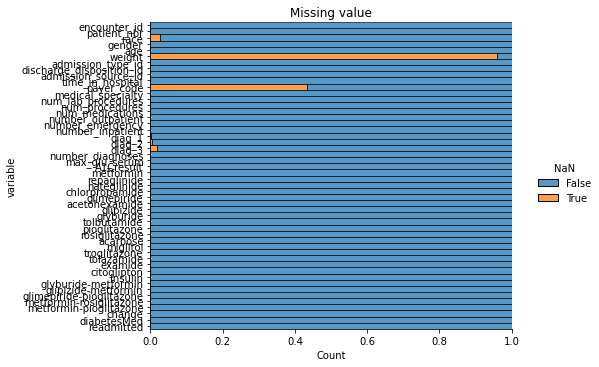

In [29]:
#plot missing values in the dataset
df = df.replace('?', np.nan)
plt.figure(figsize=(20,8))
sns.displot(
    data = df.isna().melt(value_name='NaN'),
    y="variable",
    hue="NaN",
    multiple="fill",
    aspect=1.50
)

plt.title("Missing value")

Target label distribution

In [30]:
df.groupby('readmitted').size()

readmitted
<30     6293
>30    22240
NO     42985
dtype: int64

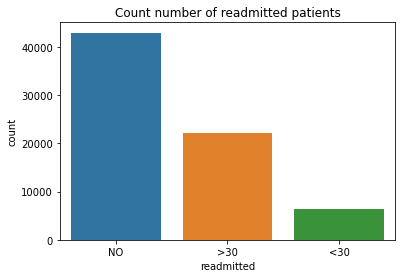

In [31]:
#Visualizing the target label distribution using a bar chart
s = sns.countplot(x = 'readmitted', data = df, order = df['readmitted'].value_counts(ascending = False).index)
plt.title('Count number of readmitted patients')
plt.show()

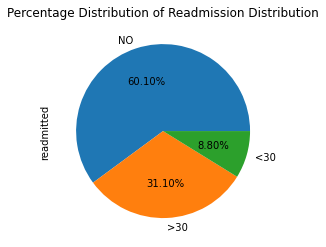

In [32]:
df.readmitted.value_counts().plot.pie(autopct = "%.2f%%")
plt.title("Percentage Distribution of Readmission Distribution")
plt.show()

Different variable Distributions

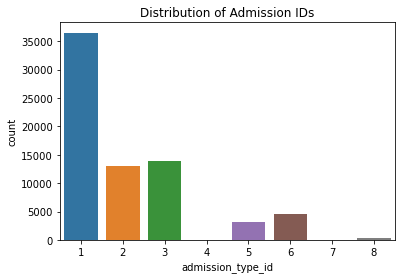

{'Emergency': 1, 'Urgent': 2, 'Elective': 3, 'Newborn': 4, 'Not Available': 5, 'NULL': 6, 'Trauma Center': 7, 'Not Mapped': 8}


In [33]:
# Adimission Type
sns.countplot(x = "admission_type_id", data = df)
plt.title("Distribution of Admission IDs")
plt.show()
cat = {'Emergency' : 1, 'Urgent' : 2, 'Elective' : 3, 'Newborn' : 4, 'Not Available' : 5, 'NULL' : 6, 'Trauma Center' : 7, 'Not Mapped' : 8}
print(cat)

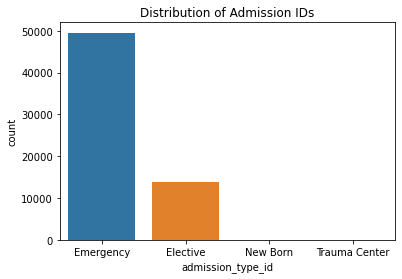

In [34]:
# Re-categoriezed Adimission Type

mapped = {1.0: "Emergency", 2.0: "Emergency", 3.0: "Elective", 4.0: "New Born",
          5.0: np.nan, 6.0: np.nan, 7.0: "Trauma Center", 8.0: np.nan}

df.admission_type_id = df.admission_type_id.replace(mapped)

sns.countplot(x = "admission_type_id", data = df)
plt.title("Distribution of Admission IDs")
plt.show()

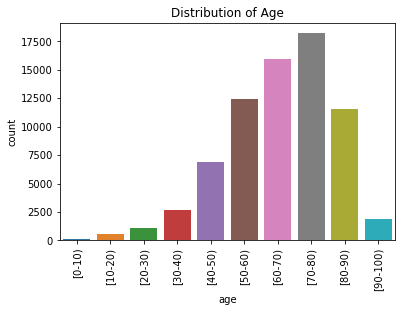

In [35]:
sns.countplot(x="age", data = df)
plt.xticks(rotation = 90)
plt.title("Distribution of Age")
plt.show()

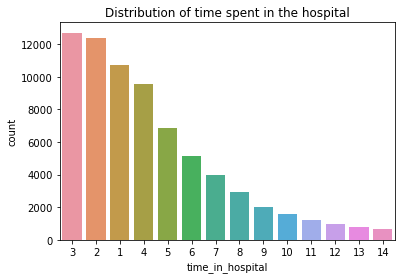

In [36]:
sns.countplot(x = "time_in_hospital", data = df,
              order = df.time_in_hospital.value_counts().index)
plt.title("Distribution of time spent in the hospital")
plt.show()

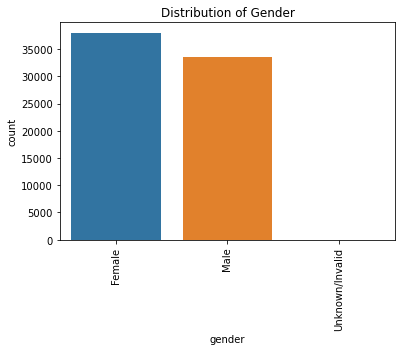

In [39]:
sns.countplot(x=df.gender, data = df)
plt.xticks(rotation=90)
plt.title("Distribution of Gender")
plt.show()

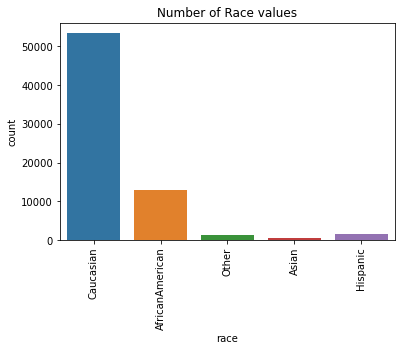

In [38]:
sns.countplot(x=df.race, data = df)
plt.xticks(rotation=90)
plt.title("Number of Race values")
plt.show()

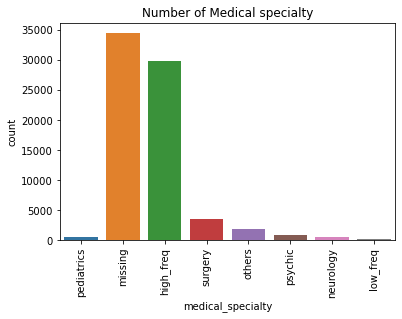

In [40]:
sns.countplot(x=df.medical_specialty, data = df)
plt.xticks(rotation=90)
plt.title("Number of Medical specialty")
plt.show()

Check Skewness in the data

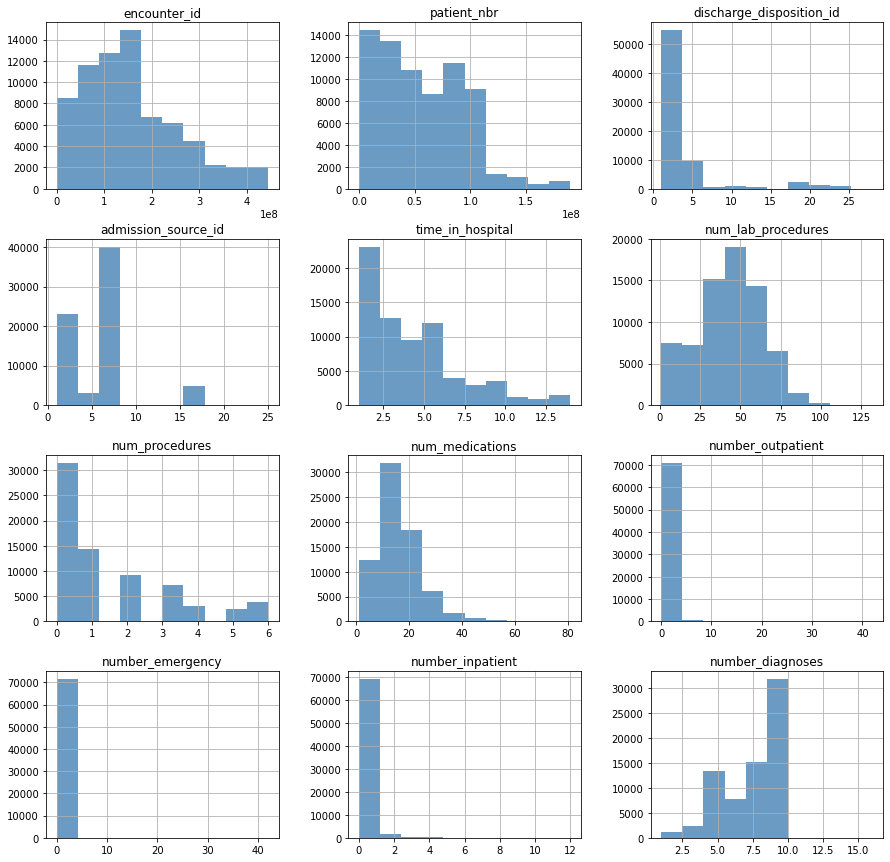

number_emergency            21.149176
number_outpatient            9.679206
number_inpatient             5.545911
discharge_disposition_id     2.641257
num_medications              1.425563
num_procedures               1.222526
time_in_hospital             1.171409
admission_source_id          1.071463
encounter_id                 0.780180
patient_nbr                  0.526240
num_lab_procedures          -0.215155
number_diagnoses            -0.741093
dtype: float64


C:\Users\skarut2\AppData\Local\Temp/ipykernel_26580/3178321634.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skew = df.skew().sort_values(ascending = False)


In [42]:
df.hist(rwidth = None, log = False, figsize = (15,15), color = 'steelblue', alpha = 0.8, label = 'Value', linewidth = 2, stacked = False)
plt.show()
skew = df.skew().sort_values(ascending = False)
print(skew)

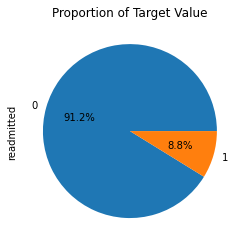

In [44]:
df['readmitted'] = df['readmitted'].map({'NO': 0, '<30': 1, '>30': 0})
df.readmitted.value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion of Target Value")
plt.show()

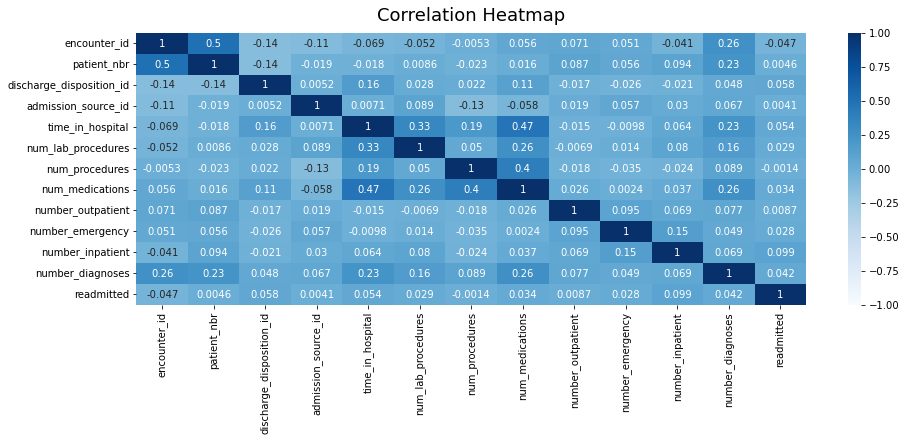

In [45]:
#visualizing the correlation between different variables
plt.figure(figsize=(15, 5))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Comparision of the target variable with features

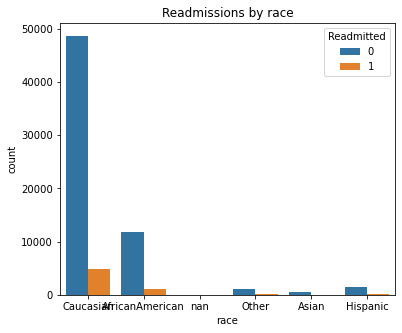

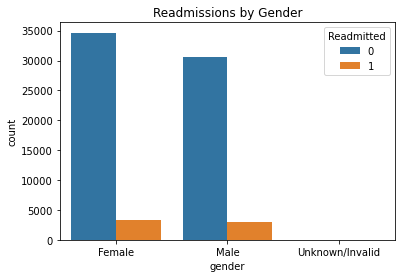

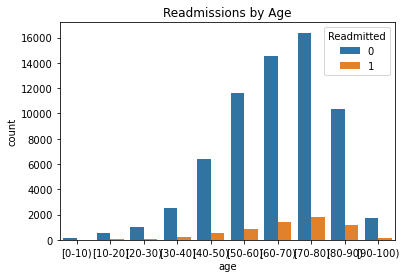

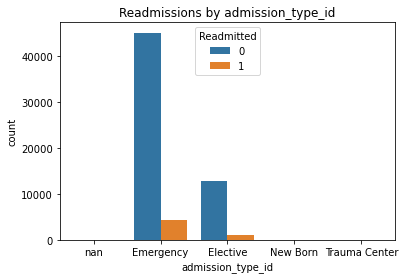

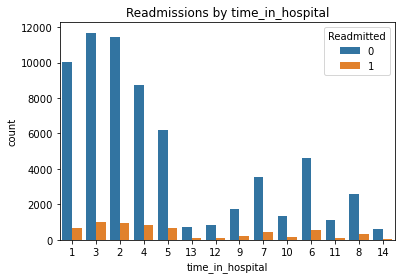

In [46]:
#Exploring the data 
plt.figure(figsize=(6,5))

race_plt = sns.countplot(x = 'race', hue = 'readmitted', data = df, order = df.race.unique().tolist()) 
race_plt.legend(title = 'Readmitted', labels = ('0', '1'))
race_plt.axes.set_title('Readmissions by race')
plt.show();

gender_plt = sns.countplot(x = 'gender', hue = 'readmitted', data = df, order = df.gender.unique().tolist()) 
gender_plt.legend(title = 'Readmitted', labels = ('0', '1'))
gender_plt.axes.set_title('Readmissions by Gender')
plt.show();

age_plt = sns.countplot(x = 'age', hue = 'readmitted', data = df, order = df.age.unique().tolist()) 
age_plt.legend(title = 'Readmitted', labels = ('0', '1'))
age_plt.axes.set_title('Readmissions by Age')
plt.show();

diag_plt = sns.countplot(x = 'admission_type_id', hue = 'readmitted', data = df, order = df.admission_type_id.unique().tolist()) 
diag_plt.legend(title = 'Readmitted', labels = ('0', '1'))
diag_plt.axes.set_title('Readmissions by admission_type_id')
plt.show();

time_plt = sns.countplot(x = 'time_in_hospital', hue = 'readmitted', data = df, order = df.time_in_hospital.unique().tolist()) 
time_plt.legend(title = 'Readmitted', labels = ('0', '1'))
time_plt.axes.set_title('Readmissions by time_in_hospital')
plt.show();

Rearranging the categorical variables

In [47]:
mapped_discharge = {1:"Discharged to Home", 6:"Discharged to Home", 8:"Discharged to Home", 13:"Discharged to Home",
                    19:"Discharged to Home", 18:np.nan, 25:np.nan, 26:np.nan, 2:"Other", 3:"Other", 4:"Other", 5:"Other", 7:"Other", 9:"Other",
                    10:"Other", 11:"Other", 12:"Other", 14:"Other", 15:"Other", 16:"Other", 17:"Other", 20:"Other", 21:"Other", 22:"Other", 23:"Other", 24:"Other",
                    27:"Other", 28:"Other", 29:"Other", 30:"Other"}

df["discharge_disposition_id"] = df["discharge_disposition_id"].replace(mapped_discharge)
df['discharge_disposition_id'].unique()

array([nan, 'Discharged to Home', 'Other'], dtype=object)

In [48]:
mapped_adm = {1:"Referral",2:"Referral",3:"Referral", 4:"Other",
              5:"Other",6:"Other",10:"Other",22:"Other",25:"Other",
              9:"Other",8:"Other",14:"Other",13:"Other",11:"Other",
              15:np.nan,17:np.nan,20:np.nan,21:np.nan, 7:"Emergency"}
df.admission_source_id = df.admission_source_id.replace(mapped_adm)
df['admission_source_id'].unique()

array(['Referral', 'Emergency', 'Other', nan], dtype=object)

In [51]:
print('Dataset dimensions : ', df.shape)

Dataset dimensions :  (71518, 50)


In [52]:
#remove variables that lead to data leakage 
df = df.drop(['encounter_id', 'patient_nbr'], axis = 1)
df = df.drop(columns = ['examide', 'citoglipton', 'diag_1', 'diag_2', 'diag_3'])

In [55]:
features = print(df.columns.values.tolist())
print('\nDataset dimensions : ', df.shape)

['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

Dataset dimensions :  (71518, 43)
